# Introduction

This notebook shows an example of relaxing the LiFePO4 crystal.

If you are running this notebook from Google Colab, uncomment the next code box to install m3gnet first.

In [ ]:
# !pip install m3gnet
# !pip install ase
# !pip install pymatgen

In [ ]:
# !pip uninstall -y numpy
# !pip uninstall -y setuptools
# !pip install setuptools
# !pip install bumpy
# !pip install numpy

In [ ]:
import warnings

import numpy as np
from pymatgen.ext.matproj import MPRester
from pymatgen.util.coord import pbc_diff

from m3gnet.models import Relaxer

for category in (UserWarning, DeprecationWarning):
    warnings.filterwarnings("ignore", category=category, module="tensorflow")

In [ ]:
mpr = MPRester("4HmCPQXiVVZmUjfuKNJSgE0G6MPLfTAA")
lfp = mpr.get_structure_by_material_id("mp-19017")  # This is LiFePO4.

lfp_strained = lfp.copy()  # We create a copy.
# Create a random strain between -5% and 5% for each direction
strains = np.random.uniform(low=-0.05, high=0.05, size=3)
lfp_strained.apply_strain(strains)
# In addition to the lattice strains, we also perturb the atoms by a distance of 0.1 angstrom.
lfp_strained.perturb(0.1)

In [ ]:
relaxer = Relaxer()
relax_results: dict
%time relax_results = relaxer.relax(lfp_strained)
relaxed_struct = relax_results["final_structure"]

CPU times: user 34.1 s, sys: 14.6 s, total: 48.7 s
Wall time: 35.3 s


Note that the relaxation only took < 20s.

The relaxation using the M3GNet universal IAP has brought the lattice parameters much closer to the original DFT ones and the coordinates are also within $10^{-3}$ of the original fractional coordinates.

In [ ]:
print(f"Original lattice parameters are {[round(x, 3) for x in lfp.lattice.abc]}")
print(f"Strained lattice parameters are {[round(x, 3) for x in lfp_strained.lattice.abc]}")
print(f"Relaxed lattice parameters are {[round(x, 3) for x in relaxed_struct.lattice.abc]}")

Original lattice parameters are [10.236, 5.971, 4.655]
Strained lattice parameters are [10.545, 6.223, 4.459]
Relaxed lattice parameters are [10.446, 6.097, 4.752]


In [ ]:
lfp_strained.frac_coords

array([[7.34314059e-05, 9.98183816e-01, 2.22823097e-02],
       [4.97457392e-01, 4.98452066e-01, 4.78502671e-01],
       [5.08577172e-01, 2.21826188e-03, 5.09052697e-01],
       [9.32979234e-03, 5.02622859e-01, 1.66337247e-03],
       [7.78170531e-01, 2.35510208e-01, 5.23206646e-01],
       [7.27272543e-01, 7.47787712e-01, 2.00400291e-02],
       [2.79280572e-01, 2.59295294e-01, 9.87884335e-01],
       [2.24820491e-01, 7.43382978e-01, 4.84906243e-01],
       [1.03050340e-01, 2.47399068e-01, 4.22874702e-01],
       [4.14309945e-01, 7.52485248e-01, 9.07803727e-01],
       [6.01254815e-01, 2.49061132e-01, 9.53736233e-02],
       [9.07944864e-01, 7.34654890e-01, 5.76278968e-01],
       [8.64879233e-02, 2.51981531e-01, 7.57437395e-01],
       [8.30454385e-01, 5.32303356e-01, 7.22911825e-01],
       [8.43241034e-01, 9.55824339e-01, 7.19859453e-01],
       [8.97548703e-01, 7.46794390e-01, 2.65457621e-01],
       [4.24299818e-02, 7.65246345e-01, 7.15385116e-01],
       [4.13311532e-01, 7.51262

In [ ]:
strained_to_orig_frac_coords_mean_diff = abs(pbc_diff(lfp_strained.frac_coords, lfp.frac_coords)).mean()

print(
    "mean diff in frac. coords. between strained and original "
    f"LFP structure: {strained_to_orig_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between strained and original LFP structure: 0.00769


In [ ]:
orig_to_m3gnet_frac_coords_mean_diff = abs(pbc_diff(lfp.frac_coords, relaxed_struct.frac_coords)).mean()

print(
    "mean diff in frac. coords. between original and M3GNet-relaxed "
    f"LFP structure: {orig_to_m3gnet_frac_coords_mean_diff:.3}"
)

mean diff in frac. coords. between original and M3GNet-relaxed LFP structure: 0.00298


In [ ]:
mean_pbc_diff_ratio = strained_to_orig_frac_coords_mean_diff / orig_to_m3gnet_frac_coords_mean_diff

print(
    f"M3GNet reduces the mean difference in frac. coords. from the strained "
    f"to the original structure by a factor of: {mean_pbc_diff_ratio:.3}"
)

M3GNet reduces the mean difference in frac. coords. from the strained to the original structure by a factor of: 2.58


# Phonon Band Structure and DOS

The M3GNet IAP can also be used to compute the lattice vibrations in a super cell.

In [ ]:
from ase.phonons import Phonons
from pymatgen.io.ase import AseAtomsAdaptor

from m3gnet.models import M3GNet, M3GNetCalculator, Potential

mp_129 = mpr.get_structure_by_material_id(mp_id := "mp-129")

# Setup crystal and EMT calculator
atoms = AseAtomsAdaptor().get_atoms(mp_129)

potential = Potential(M3GNet.load())

calculator = M3GNetCalculator(potential=potential, stress_weight=0.01)

# Phonon calculator
N = 7
supercell = (N, N, N)
ph = Phonons(atoms, calculator, supercell=supercell, delta=0.05)
ph.run()

# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)
ph.clean()

path = atoms.cell.bandpath("GHPGN", npoints=100)
bs = ph.get_band_structure(path)

dos = ph.get_dos(kpts=(20, 20, 20)).sample_grid(npts=100, width=1e-3)

WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.999e-09*i)
WARNING, 3 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 5.999e-09*i)


Text(0.5, 1.02, 'Phonon band structure and DOS of LiFePO4 Mo1 (mp-129) with (7, 7, 7) supercell')

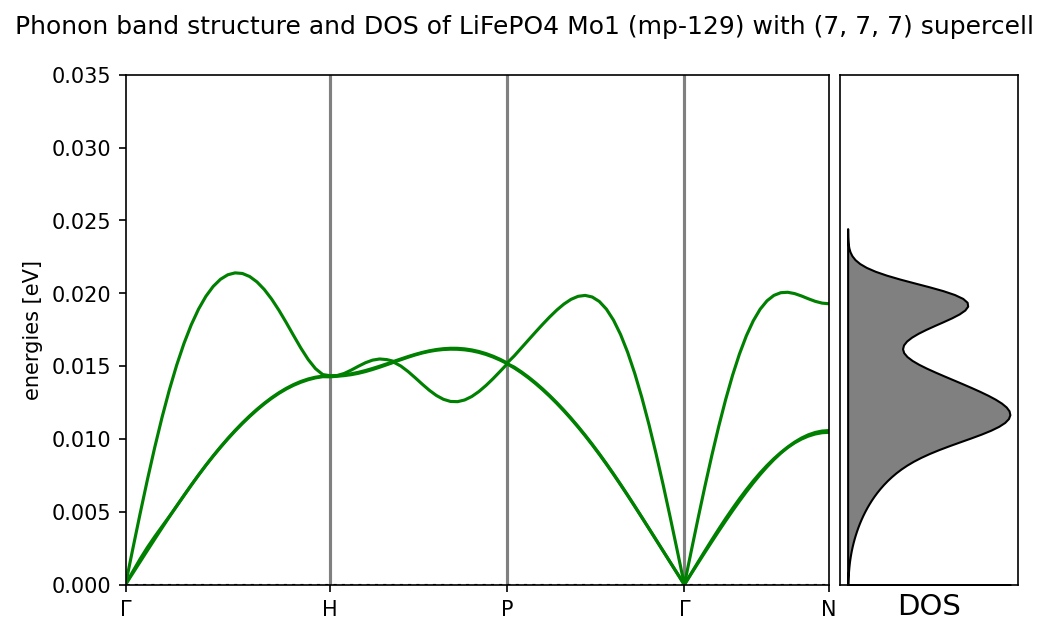

In [ ]:
# Plot the band structure and DOS:
import matplotlib.pyplot as plt

plt.rc("figure", dpi=150)

fig = plt.figure(1, figsize=(7, 4))
bs_ax = fig.add_axes([0.12, 0.07, 0.67, 0.85])

emax = 0.035
bs.plot(ax=bs_ax, emin=0.0, emax=emax)

dos_ax = fig.add_axes([0.8, 0.07, 0.17, 0.85])
dos_ax.fill_between(dos.get_weights(), dos.get_energies(), y2=0, color="grey", edgecolor="black", lw=1)

dos_ax.set_ylim(0, emax)
dos_ax.set_yticks([])
dos_ax.set_xticks([])
dos_ax.set_xlabel("DOS", fontsize=14)

fig.suptitle(
    f"Phonon band structure and DOS of LiFePO4 {mp_129.formula} ({mp_id}) with {supercell} supercell",
    fontsize=12,
    y=1.02,
)